# Investment and Trading Capstone Project: Build a Stock Price Indicator

## Emily Gou - Jan 12, 2018

This file include all of the code I used for the capstone project of the Machine Learning engineer nanodegree on Udacity. The code was tested on my laptop(macOS High Sierra10.13.2) and some lines read data from the local path which should be replaced by another path if running on another machine.

## Download data or read from local disc

In [55]:
# import modules
import os.path
from time import time
from datetime import date, datetime, timedelta
import pandas as pd
import pandas_datareader as pdr
import sys
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score


from IPython.display import display
%matplotlib inline

# set the time range of data that will be used for analysis
STDATE = datetime(2006,2,22).date() 
EDDATE = datetime(2017,12,31).date()
dates = pd.date_range('2006-02-22','2017-12-31')

# define the local path to the previously stored data
mypath = './stock_proj/'




# main functions for data retrieving

def retrieve_data(symbol):
    """   Retrieve data for a given symbol and return it.   """
    # Define CSV file path with given ticker symbol
    filename = mypath+symbol+'.csv'
    # If the data file exists, read it directly; otherwise download it from Yahoo Finance and save it to the disk.
    if os.path.isfile(filename):
        # Read CSV file and use the first column(dates) as indexes.
        df = pd.read_csv(filename, parse_dates=True, infer_datetime_format=True, index_col=0)
        # It might be better to add a line to check if the starting date and ending date is the desired one. 
        # But as we always use the same dates, so I skipped this step.
    else:
        writeflag = True
        df = download_data(STDATE, EDDATE, symbol, filename, writeflag)
    return df



def download_data(startdate, enddate, symbol, filename, writeflag):
    """   Download historical stock data of given stock from Yahoo! and return it."""
    # Use pandas_datareader to get data from Yahoo!
    symbol_data = pdr.get_data_yahoo(symbols=symbol, start=startdate, end=enddate)
    # If writeflag is true, write the CSV file to disk.
    if writeflag==True:
        symbol_data.to_csv(filename)
    return symbol_data


## Data exploration

In [56]:
# List of ticker symbols including stocks of interest and the index
symbols = ['GOOGL','BIDU','^NDXT']

# initiate an empty dataframe with indexes be dates
df = pd.DataFrame(index=dates)
df_vol = pd.DataFrame(index=dates)

# Read given stock data and show the adjusted close prices
def extract_col(symbol, colname):
    ''' Take a dataframe as input, rename and return the column specificed in colname.'''
    # Retrieve data
    df_full = retrieve_data(symbol)
    # Create a new dataframe to store the 'Adj Close' column
    df_temp = df_full[[colname]]
    # Rename the adjusted close to the stock name
    df_temp.columns = [symbol]
    return df_temp

for symbol in symbols:
    # Join the adjusted close and volume data from different stocks in the list, 
    # only store dates that all stocks have prices/volume
    df = df.join(extract_col(symbol,'Adj Close'),how='inner')
    if symbol != '^NDXT':
        df_vol = df_vol.join(extract_col(symbol,'Volume'),how='inner')

# Because the NASDAQ-100 Technology Sector Index(^NDXT) starts from Feb 22, 2006, 
# then the joined data frame also starts from that day.
# print('Adjusted close price of the two stocks and the index:')
display(df.head())

GOOGL   BIDU        ^NDXT
2006-02-22  182.927933  5.473  1012.979980
2006-02-23  189.224228  5.230  1009.190002
2006-02-24  188.888885  5.286  1012.070007
2006-02-27  195.385391  5.430  1021.070007
2006-02-28  181.491486  5.142  1009.840027

In [57]:
# Display basic statistics of the data. 
# From the count it can be observed that there are some missing data in the ^NDXT column and it would be solved later.
display(df.describe())

GOOGL         BIDU        ^NDXT
count  2986.000000  2986.000000  2983.000000
mean    430.511295   109.048974  1671.152333
std     236.464338    73.144762   777.049812
min     128.848846     4.832000   525.919983
25%     249.678425    32.463501  1097.600037
50%     311.859360   114.559998  1395.170044
75%     572.448028   170.904999  2212.270019
max    1085.089966   272.820007  4094.040039

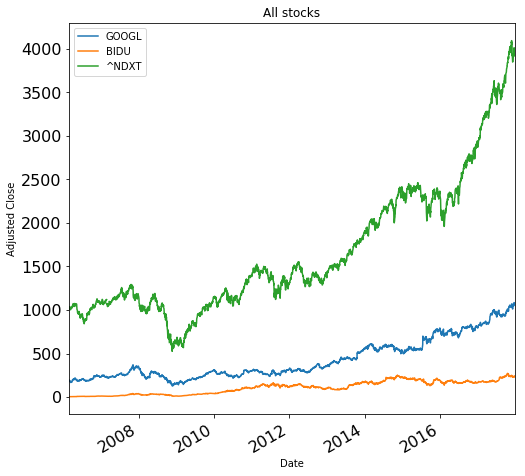

In [58]:

# Plot function
def plot_data(df, title="Stock prices", xlabel="Date", ylabel="Price"):
    """Plot stock prices with a custom title and meaningful axis labels."""
    ax = df.plot(title=title, fontsize=16, figsize=(8, 8))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.show()

# Plot the three stocks. Set the title and x,y labels
plot_data(df,title='All stocks',ylabel='Adjusted Close')

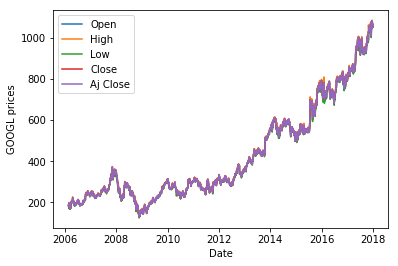

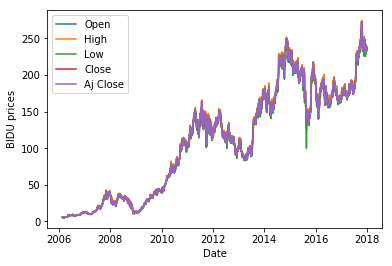

In [59]:
def stock_plot_all(symbol):
    ''' Plot all columns of the historical data except the volume.'''
    fname = symbol+'_prices.eps'
    df_symbol = retrieve_data(symbol)
    df_symbol = df_symbol.drop(['Volume'],axis=1)
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(df_symbol)
    ax.legend(['Open', 'High', 'Low', 'Close', 'Aj Close'], loc = 'upper left')
    plt.ylabel(symbol+' prices')
    plt.xlabel('Date')
    plt.show()
    fig.savefig(fname)
    plt.close(fig)
stock_plot_all('GOOGL')
stock_plot_all('BIDU')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x116825cd0>,
      dtype=object)

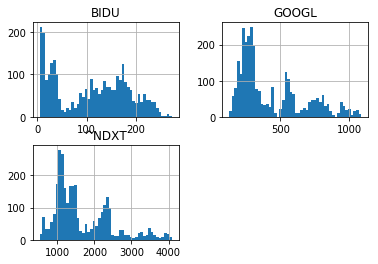

In [60]:
# Plot the histogram of historical adjusted close prices
df.hist(bins=50)

In [61]:
# Obtain basic statistics of the volume data
display(df_vol.describe())

GOOGL          BIDU
count  2.986000e+03  2.986000e+03
mean   6.205470e+06  1.476517e+07
std    5.674371e+06  2.122667e+07
min    5.206000e+05  9.203000e+05
25%    2.268675e+06  3.176725e+06
50%    4.572500e+06  6.166350e+06
75%    8.007000e+06  1.684860e+07
max    7.879630e+07  2.005490e+08

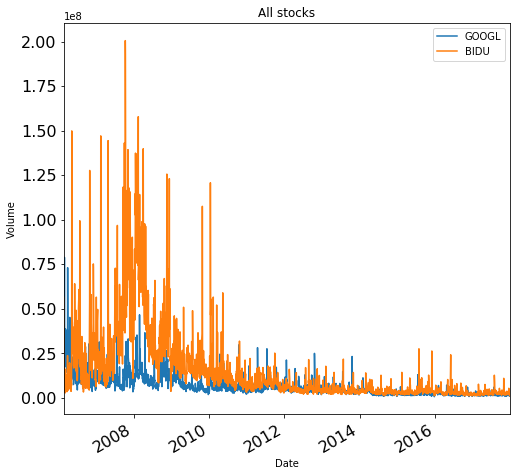

In [62]:
# Plot the volume of each stock as a function of time
plot_data(df_vol,title='All stocks',ylabel='Volume')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1188af190>,
      dtype=object)

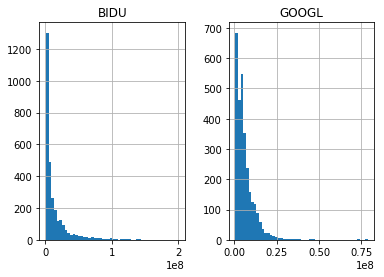

In [63]:
# Plot the histogram of the volume of each stock
df_vol.hist(bins=50)

## Calculate and visulize basic features of stock data

Based on the 'Machine Learning for trading' course on Udacity, we can calculate and plot some basic features of stock data.

In [64]:
# The following functions are adopted from the online course 'Machine Learning for trading' on Udacity.
def get_rolling_mean(values, window):
    """Return rolling mean of given values, using specified window size."""
    return values.rolling(window=window,center=False).mean()


def get_rolling_std(values, window):
    """Return rolling standard deviation of given values, using specified window size."""
    return values.rolling(window=window,center=False).std()


def get_bollinger_bands(rm, rstd):
    """Return upper and lower Bollinger Bands."""
    upper_band = rm + 2*rstd
    lower_band = rm - 2*rstd
    return upper_band, lower_band

def compute_daily_returns(df):
    """Compute the daily return values."""
    # Create a copy of the original datafram
    r_df = df.copy()
    # Calculate ratio of n+1/n day
    r_df = (df / df.shift(1)) - 1
    # Deal with initial value
    r_df.loc[r_df.index[[0]], :] = 0
    # alternative way: 
    # r_df = df.pct_change()
    return r_df


def compute_cumulative_returns(df):
    """Compute the cumulative return values."""
    # Calculate ratio of N/1 day
    cr_df = (df.iloc[[-1]]/df.values[0,:])-1
    return cr_df


def fill_missing_values(df):
    """ Fill missing values in data frame, in place. """
    # Fill forward first, and then fill backward.
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)
    return df

def sharpe_ratio(df):
    """ Compute the sharpe ratio of stocks."""
    return np.sqrt(252) * (df.mean()/df.std())

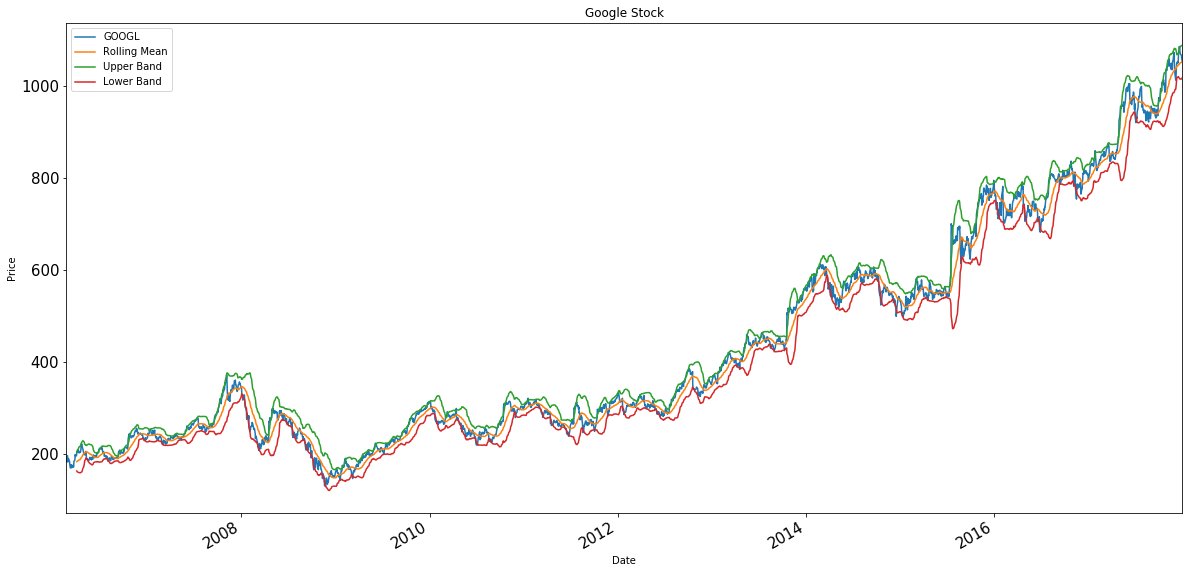

In [65]:
# Use above functions to visulize basic features such as bollinger bands and daily return of selected stocks

# Take GOOGL as an example to show the bollinger bands and daily return
symbol = symbols[0]
# symbol = symbols[1]
# Extrace adjusted close data of google stock
googl_ac = extract_col(symbol, 'Adj Close')

# Window size
window_size = 30

# Rolling mean of google stock
rm_googl = get_rolling_mean(googl_ac, window=window_size)

# Rolling standard derivation of google stock
rstd_googl = get_rolling_std(googl_ac, window=window_size)

# Upper and lower bollinger bands of google stock
upper_band_googl, lower_band_googl = get_bollinger_bands(rm_googl, rstd_googl)

# Plot google stock prices and bollinger bands
plt_ftsize = 15
ax = googl_ac.plot(title="Google Stock", label='Stock prices',fontsize=plt_ftsize, figsize = (20,10))
ax.plot(rm_googl.index, rm_googl,label='Rolling Mean')
ax.plot(upper_band_googl.index, upper_band_googl, label='Upper Band')
ax.plot(lower_band_googl.index, lower_band_googl, label='Lower Band')

ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.legend(loc='upper left')
plt.show()

Note the Bollinger bands starts several days after the date of record, and the gap varies with the window size.

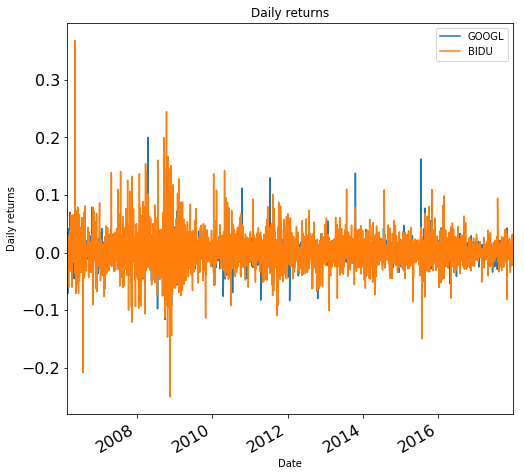

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11848c950>,
      dtype=object)

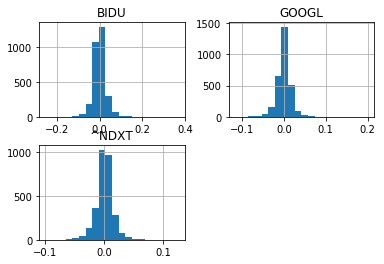

In [66]:
# Compute daily returns
daily_returns = compute_daily_returns(df)

# Filling the missing value of ^NDXT otherwise error appears when calculating correlation
daily_returns = fill_missing_values(daily_returns)
plot_data(daily_returns[['GOOGL','BIDU']], title="Daily returns", ylabel="Daily returns")

# Plot histograms of daily return for each stock
daily_returns.hist(bins=20)

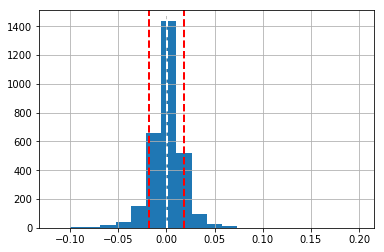

In [67]:
# Plot the histogram of google stock
symbol = symbols[0]
# symbol = symbols[1]
daily_returns[symbol].hist(bins=20)
    
# Get mean as standard deviation
mean_googl = daily_returns[symbol].mean()
std_googl = daily_returns[symbol].std()

plt.axvline(mean_googl, color='w', linestyle='dashed', linewidth=2)
plt.axvline(std_googl, color='r', linestyle='dashed', linewidth=2)
plt.axvline(-std_googl, color='r', linestyle='dashed', linewidth=2)
plt.show()

In [68]:
# Compute kurtosis
print "The kurtosis of each stock's daily return is:"
display( daily_returns.kurtosis())

The kurtosis of each stock's daily return is:


GOOGL    13.823856
BIDU     12.789623
^NDXT     5.054875
dtype: float64

Text(0.5,1,u'Baidu and ^NDXT')

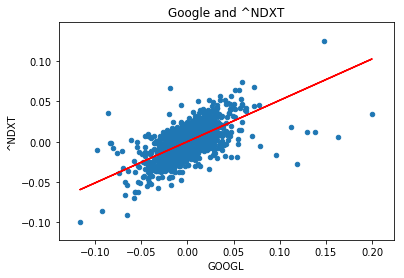

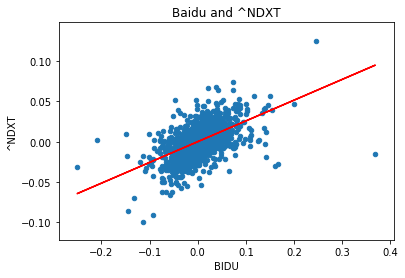

In [69]:
# Generate scatterplots and visualize the correlation between the two stocks and the index
daily_returns.plot(kind='scatter', x='GOOGL', y='^NDXT')
beta_googl, alpha_googl = np.polyfit(daily_returns['GOOGL'], daily_returns['^NDXT'], 1)
plt.plot(daily_returns['GOOGL'], beta_googl*daily_returns['GOOGL'] + alpha_googl, '-', color='r')
plt.title('Google and ^NDXT')


daily_returns.plot(kind='scatter', x='BIDU', y='^NDXT')
beta_bidu, alpha_bidu = np.polyfit(daily_returns['BIDU'], daily_returns['^NDXT'], 1)
plt.plot(daily_returns['BIDU'], beta_bidu*daily_returns['BIDU'] + alpha_bidu,  color='r')
plt.title('Baidu and ^NDXT')


In [70]:
# Calculate correlations
daily_returns.corr(method='pearson')

GOOGL      BIDU     ^NDXT
GOOGL  1.000000  0.474714  0.624243
BIDU   0.474714  1.000000  0.537866
^NDXT  0.624243  0.537866  1.000000

In [71]:
# Compute the cumulative return of each stock and the index
cumul_return = compute_cumulative_returns(df)
print('The cumulative return is:')
display(cumul_return)

# Sharpe ratio of each stock and the index
display(pd.DataFrame(data = sharpe_ratio(df), columns = ['Sharpe Ratio']))

The cumulative return is:


GOOGL       BIDU     ^NDXT
2017-12-29  4.758552  41.793716  2.870718

Sharpe Ratio
GOOGL     28.901419
BIDU      23.666750
^NDXT     34.140309

## Benchmark model

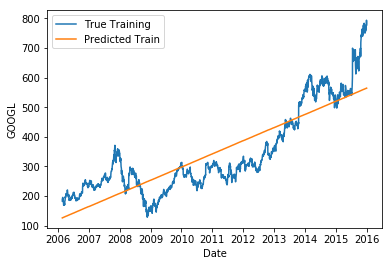

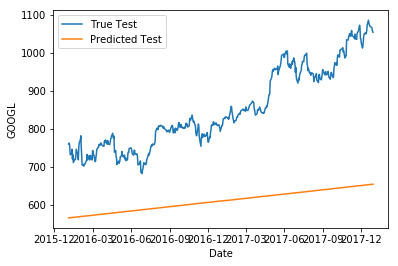

meanabsperc_test  meanabsperc_train  meansquare_test  \
GOOGL BM model         27.721227          31.775982     65533.458431   

                meansquare_train  pred_time  train_time  
GOOGL BM model       3967.932564   0.000823    0.001655

In [72]:
from scipy import stats

def mean_abs_percentage_error(y_test, y_pred): 
    ''' Find the mean absolute percentage error. Note
    when using this metrics, need to make sure the true values 
    y_test has no zero entries.'''
    # Convert the input dataframes into arrays
    y_test = np.array(y_test)
    y_pred = np.array(y_pred)
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100



def benchmark_model(t, df):
    ''' This is the benchmark model.'''
    slope, intercept, r_value, p_value, std_err = stats.linregress(t,df.values[:,0])
    return slope, intercept

def stock_plot(x,y,labels,symbol):
    ''' Plot function for the test data and prediction.'''
    fname = symbol+'.eps'
    fig = plt.figure() #figsize=[10,8]
    ax = plt.axes()
    # ax.xaxis.set_major_locator(xtick_locator)
    # ax.xaxis.set_major_formatter(xtick_formatter)
    if type(y) is list:
        i=0
        for yi in y:
            ax.plot(x,yi,label=labels[i])
            i = i+1
    else:
        ax.plot(x,y)
    ax.legend(loc='upper left')
    plt.ylabel(symbol)
    plt.xlabel('Date')
    plt.show()
    fig.savefig(fname)
    plt.close(fig)


# Take the ticker symbol
symbol = symbols[0]
# Extrace adjusted close data of google stock
stock_adj = extract_col(symbol, 'Adj Close')
# train_dates = pd.date_range('2006-02-22','2016-12-30')
# test_dates = pd.date_range('2017-01-03','2017-12-29')

# training dates
st_train = datetime(2006,2,22) 
ed_train = datetime(2015,12,31) 

# testing dates
st_test = datetime(2016,1,4) 
ed_test = datetime(2017,12,29) 
y_train = stock_adj.loc[st_train:ed_train,:]
y_test = stock_adj.loc[st_test:ed_test,:]
# Define the x variable as time
t_train = np.array(range(0,len(y_train)))

# record the metrics
result_benchmark = {}
start = time()
# Fit the model
m,b = benchmark_model(t_train, y_train)

# Predict the results
y_train_pred = pd.DataFrame(data=m*t_train+b,index=y_train.index)
end = time()
result_benchmark['train_time'] = end - start

# plot the fitted model and the training data
stock_plot(y_train.index,[y_train, y_train_pred],['True Training', 'Predicted Train'],symbol)

start = time()
# get the testing dates
t_test = np.array(range(len(y_train),len(y_train)+len(y_test)))
# Use the calculated slope and intercept to calculate the predicted testing data
y_test_pred = pd.DataFrame(data=m*t_test+b,index=y_test.index)
end = time() 
result_benchmark['pred_time'] = end - start
stock_plot(y_test.index,[y_test, y_test_pred],['True Test', 'Predicted Test'],symbol)

# calculate the mean square and mean absolute percentage error for the training and testing data
sampletrain = 50
result_benchmark['meansquare_train'] = mean_squared_error(y_train[:sampletrain], y_train_pred[:sampletrain])
result_benchmark['meanabsperc_train'] = mean_abs_percentage_error(y_train[:sampletrain], y_train_pred[:sampletrain])

result_benchmark['meansquare_test'] = mean_squared_error(y_test, y_test_pred)
result_benchmark['meanabsperc_test'] = mean_abs_percentage_error(y_test, y_test_pred)

result_bdf = pd.DataFrame(result_benchmark,index = [symbol+' BM model'])
display(result_bdf)

## Data preprocessing

### Prediction with Raw data

In the following, I will start to preprocess the stock data.

In [73]:
import matplotlib.ticker as plticker
from matplotlib.dates import AutoDateFormatter, AutoDateLocator
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

import pickle

xtick_locator = AutoDateLocator()
xtick_formatter = AutoDateFormatter(xtick_locator)


reg = ['linreg', 'svr', 'knr', 'mlp', 'rdf']

# stock prediction with features such as open, high, low prices
def stock_predft(symbol,method, startdate, enddate, testdates, lag, n_in):
    """ Main prediction function. Take ticker symbol, prediction method, 
    time range for training and testing, time lag as input. Output 
    the predicted value of the stock price. """
    # Obtain all data of given ticker symbol from 2006-02-22 to 2017-12-31
    df = retrieve_data(symbol)
    # Get dates from index
    tddates = df.index.date
    # Take the adjusted close prices only.
    df_adj = df.drop(['Close', 'Volume', 'Open', 'High', 'Low'], axis=1)
    # Convert the time series of price data to a supervised learning problem
    # if lag=1, predit 1 day later. For example, use 2017.10.01 data to predict 2017.10.03 price
    df_new = series_to_supervised(df_adj, n_in=n_in, lag=lag, dropnan=True)
    # Obtain traning data
    X_train, y_train, testdates_new = get_data(df_new, tddates, startdate, enddate, testdates, trainflag=True, fcnflag=1)
    # Obtain testing data
    X_test, y_test, testdates_new = get_data(df_new, tddates, startdate, enddate, testdates, trainflag=False, fcnflag=1)
    # Optionally normalize data
    # X_train = normal_data(X_train, 'minmax')
    # X_test = normal_data(X_test, 'minmax')
    # Input the data for training and obtain the results
    results, pred_train, pred_test, y_train, y_test = train_predict(symbol, method, X_train, y_train, X_test, y_test, 'fcn1')
    return results, pred_train, pred_test, y_train, y_test, testdates_new





In [74]:
def series_to_supervised(data, n_in=1, lag=0, dropnan=True):
    """
    Adapted from Dr. Jason Brownlee's blog post: 
    https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
    
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    # number of features+outputs
    n_vars = 1 if type(data) is list else data.shape[1] 
    df = pd.DataFrame(data)
    outputs = df['Adj Close']
    col_names = data.columns.values
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(col_names[j]+'(t-%d)' % i) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    # if cont:
    #     for i in range(0, n_out):
    #         cols.append(outputs.shift(-i))
    #         if i == 0:
    #             names += ['Adj Close(t)']
    #         else:
    #             names += [('Adj Close(t+%d)' % i)]
    # else:
    # default lag=0, and it means only predict the stock price one day after
    cols.append(outputs.shift(-lag))
    names += ['Adj Close(t)']
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


def get_data(df, tddates, startdate, enddate, testdates, trainflag=True, fcnflag=1):
    """ Take startdate and enddate as inputs, return the features, output data in corresponding time range,
    as well as the testdates data. 
    Parameters:
        df: dataset containing all adjusted price data
        tddates: a series of dates, same as the indexes of df 
        startdate: starting date of training data
        enddate: ending date of training data
        testdates: dates for testing
        trainflag: True if the returned data is for training, False for testing
        fcnflag: 1 if the model is not benchmark model, 2 is for benchmark model
    Return:
        feature_dt: feature columns
        output_dt: output columns
        testdates_new: new indexes for testing data. Used when the testing date is given in a range."""
    testdates_new = []
    if trainflag: # for training data, given startdate and enddate
        stidx = np.searchsorted(tddates, startdate)
        edidx = np.searchsorted(tddates, enddate)
        selected_date = df[stidx:edidx+1]
        # selected_date.dropna(inplace=True)
    else:
        
        # selected_list = df.index.isin(testdates)
        # selected_date = df[selected_list]
        # selected_date.dropna(inplace=True)
        selected_date = df[df.index.isin(testdates)]
        testdates_new = selected_date.index.date

    if fcnflag==1: # for the first approach with function stock_predft
        output_dt = selected_date.loc[:, 'Adj Close(t)':]
        feature_dt = selected_date.loc[:, :'Adj Close(t-1)']
    else:          # for the second approach with function stock_predtime
        output_dt = selected_date['Adj Close']
        feature_dt = selected_date.drop('Adj Close', axis=1)
    return feature_dt, output_dt, testdates_new


def normal_data(X, scalemethod):
    '''Normalize each column using given scaler'''
    # Initialize a scaler, then apply it to the features
    if scalemethod == 'minmax':
        scaler = MinMaxScaler() 
    elif scalemethod == 'standard':
        scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_norm = pd.DataFrame(X_scaled, index=X.index, columns=X.columns.values)
    return X_norm

def merge_df(data1,data2,names2):
    """ Merge two data frame, must have the same rows. 
    Columns in data2 are names using given strings names2. """
    # take the column names in data1 as a series
    col_names = data1.columns.values
    # convert list to array
    names2 = np.array(names2)
    # concatenate column names arrays
    new_names = np.concatenate([col_names, names2])
    # concatenate two dataframe along columns
    data_new = pd.concat([data1,data2], axis=1)
    # assign new column names to the obtained new dataframe
    data_new.columns = new_names
    return data_new



In [75]:
def train_predict(symbol, method, X_train, y_train, X_test, y_test, fcn): 
    ''' Main function for model training and error evaluation. '''
    if method == 'linreg':
        learner = LinearRegression()
    else:
        if method == 'svr':
            learner = SVR(kernel='linear', C=0.1)
        elif method == 'knr':
            learner = KNeighborsRegressor(n_neighbors=7)
        elif method == 'mlp':
            learner = MLPRegressor(hidden_layer_sizes=10, random_state=0)
        elif method == 'randf':
            learner = RandomForestRegressor(random_state=0)
    # if method in ['svr']: # Normalize data when using SVR model to speed up the model fitting
    #    X_train = normal_data(X_train, 'standard')
    #    X_test = normal_data(X_test, 'standard')
    # dictionary used to record results
    results = {}
    # number of samples in the training set to calculate training error
    sampletrain = 50
    start = time() # Get start time
    # flatten output value and fit the model
    if method == 'linreg':
        learner = learner.fit(X_train,y_train)
    else:
        learner = learner.fit(X_train,y_train.values.ravel())
    end = time() # Get end time
    results['train_time'] = end - start

    start = time() # Get start time
    # fit the testing data
    pred_test = learner.predict(X_test)
    pred_train = learner.predict(X_train[:sampletrain])
    end = time() # Get end time
    results['pred_time'] = end - start
    
    # calculate errors, mean square and mean absolute percentage for the training set
    results['meansquare_train'] = mean_squared_error(y_train[:sampletrain], pred_train)
    results['meanabsperc_train'] = mean_abs_percentage_error(y_train[:sampletrain], pred_train)
    # calculate errors, mean square and mean absolute percentage for the test set
    results['meansquare_test'] = mean_squared_error(y_test, pred_test)
    results['meanabsperc_test'] = mean_abs_percentage_error(y_test, pred_test)

#    results['r2_train'] = r2_score(y_train[:sampletrain], pred_train) 
#    results['r2_test'] = r2_score(y_test, pred_test)
    if learner.__class__.__name__ == 'RandomForestRegressor':
        importances = learner.feature_importances_
        print(importances)
    # print "{} trained on {}.".format(learner.__class__.__name__, X_train.shape[0])
    # save trained model and outputs to file
    filename = symbol+'_'+method+'_'+fcn+'.pickle'
    with open(filename, 'w') as f:
        pickle.dump([learner, results, pred_train, pred_test, y_train, y_test],f)
    return results, pred_train, pred_test, y_train, y_test


### Predict GOOGL stock prices with the first approach

In [76]:
methods = ['linreg', 'svr', 'knr', 'mlp', 'randf']
symbol = 'GOOGL'
plotflag = False
if plotflag:
    # stock_plot(tddates,[adj_close, open_price, close_price, high_price, low_price],symbol)
    # stock_plot(tddates,df['Open', 'High', 'Low', 'Close'],symbol)
    stock_plot(tddates,adj_close,symbol)
# Specify data for training
startdate = datetime(2006,2,22).date()
enddate =  datetime(2015,12,31).date()
# Specify data for testing
teststdate = datetime(2016,1,1).date()
testeddate = datetime(2017,12,31).date()
# Frequency for choosing the testing dates
freq = 1
weekend = set([5, 6])
# Delete testing dates that are weekends
testdates = [teststdate + timedelta(days=x) for x in range(0,(testeddate-teststdate).days + 1,freq) 
     if (teststdate + timedelta(days=x)).weekday() not in weekend]
# 
results = {}
df_test = pd.DataFrame()
for method in methods:
    result, pred_train, pred_test, y_train, y_test, testdates_new = stock_predft(symbol,method, startdate, enddate, testdates, lag=0, n_in=5)
    results[method] = result
    pred_test = pd.DataFrame(data = pred_test, columns=[method])
    if method == 'linreg':
        df_test = df_test.append(pred_test)
    else:
        df_test = pd.concat([df_test, pred_test],axis=1)
    #    stock_plot(y_test.index,[y_test, pred_test],['Test True', 'Test Pred, 1st approach'],symbol)
    # print(result)
y_test.columns=['True price']
df_test.index = y_test.index
df_test = pd.concat([df_test, y_test],axis=1)

results_df = pd.DataFrame(results)
display(results_df)

/anaconda/envs/uda_stock/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[3.06010938e-04 8.29437941e-04 8.21860045e-03 8.44146173e-03
 9.82204489e-01]


knr     linreg         mlp         randf  \
meanabsperc_test      11.524002   0.803597   14.073519     11.416861   
meanabsperc_train      8.629948   1.694383    8.804230      8.698177   
meansquare_test    17674.593897  87.457582  104.015424  16947.301281   
meansquare_train      22.159076  19.039108   28.422162      4.802431   
pred_time              0.008874   0.000672    0.002305      0.004197   
train_time             0.017670   0.001901    1.794221      0.233327   

                         svr  
meanabsperc_test   14.106595  
meanabsperc_train   8.811695  
meansquare_test    87.346858  
meansquare_train   19.171009  
pred_time           0.029122  
train_time         31.956260

linreg         svr         knr         mlp       randf  \
Date                                                                     
2016-01-04  777.566902  777.879699  769.385716  770.703911  765.235998   
2016-01-05  759.372708  759.542401  761.250000  754.458630  756.962012   
2016-01-06  762.559553  761.811966  762.008571  758.049961  758.131006   
2016-01-07  760.153877  760.003756  761.205706  767.763364  749.103998   
2016-01-08  740.917193  741.320483  754.375715  747.284544  736.982977   

            True price  
Date                    
2016-01-04  759.440002  
2016-01-05  761.530029  
2016-01-06  759.330017  
2016-01-07  741.000000  
2016-01-08  730.909973

Text(0,0.5,u'Adjusted Close')

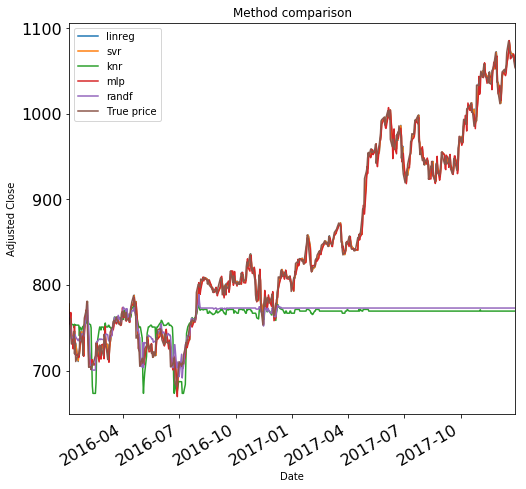

In [77]:
display(df_test.head())
ax = df_test.plot(title='Method comparison', fontsize=16, figsize=(8, 8))
ax.set_xlabel('Date')
ax.set_ylabel('Adjusted Close')

### Predict BIDU stock prices with the first approach

In [78]:
methods = ['linreg', 'svr', 'knr', 'mlp', 'randf']
symbol = 'BIDU'
plotflag = False
if plotflag:
    # stock_plot(tddates,[adj_close, open_price, close_price, high_price, low_price],symbol)
    # stock_plot(tddates,df['Open', 'High', 'Low', 'Close'],symbol)
    stock_plot(tddates,adj_close,symbol)
# Specify data for training
startdate = datetime(2006,2,22).date()
enddate =  datetime(2015,12,31).date()
# Specify data for testing
teststdate = datetime(2016,1,1).date()
testeddate = datetime(2017,12,31).date()
# Frequency for choosing the testing dates
freq = 1
weekend = set([5, 6])
# Delete testing dates that are weekends
testdates = [teststdate + timedelta(days=x) for x in range(0,(testeddate-teststdate).days + 1,freq) 
     if (teststdate + timedelta(days=x)).weekday() not in weekend]
# 
results = {}
df_test = pd.DataFrame()
for method in methods:
    result, pred_train, pred_test, y_train, y_test, testdates_new = stock_predft(symbol,method, startdate, enddate, testdates, lag=0, n_in=5)
    results[method] = result
    pred_test = pd.DataFrame(data = pred_test, columns=[method])
    if method == 'linreg':
        df_test = df_test.append(pred_test)
    else:
        df_test = pd.concat([df_test, pred_test],axis=1)
    # print(result)
y_test.columns=['True price']
df_test.index = y_test.index
df_test = pd.concat([df_test, y_test],axis=1)

results_df = pd.DataFrame(results)
display(results_df)


[5.73706368e-03 5.27393720e-03 4.71592839e-04 1.01446877e-02
 9.78372719e-01]


knr     linreg        mlp      randf        svr
meanabsperc_test   14.601893   1.311561  14.873561  14.664739  14.929085
meanabsperc_train   9.855032   3.480781  23.725826  11.154996   9.860145
meansquare_test    31.249579  12.471624  16.353712  27.478272  12.525323
meansquare_train    0.110856   0.129735   1.594823   0.043762   0.122740
pred_time           0.005224   0.000698   0.000912   0.005693   0.022600
train_time          0.003312   0.001520   1.783793   0.184821  27.011696

linreg         svr         knr         mlp       randf  \
Date                                                                     
2016-01-04  188.900519  188.887425  188.977140  188.415879  185.519998   
2016-01-05  184.104237  184.155078  186.995714  183.534622  186.761000   
2016-01-06  187.865986  187.756721  185.952857  186.554453  186.699002   
2016-01-07  185.615875  185.560515  185.051431  189.032962  179.829997   
2016-01-08  173.750370  174.009179  183.122859  175.907972  171.571997   

            True price  
Date                    
2016-01-04  184.029999  
2016-01-05  187.369995  
2016-01-06  185.610001  
2016-01-07  174.369995  
2016-01-08  171.339996

Text(0,0.5,u'Adjusted Close')

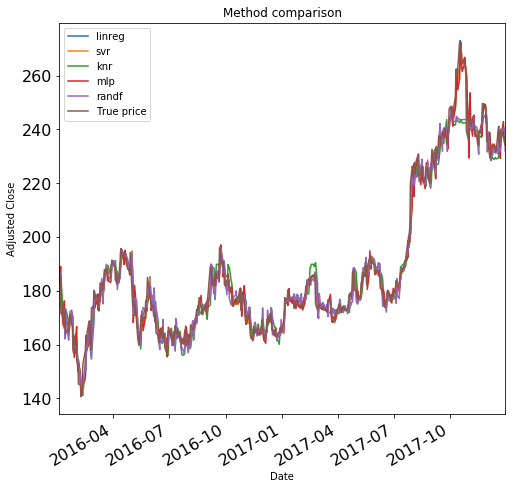

In [79]:
display(df_test.head())
ax = df_test.plot(title='Method comparison', fontsize=16, figsize=(8, 8))
ax.set_xlabel('Date')
ax.set_ylabel('Adjusted Close')

### Prediction with Technical Indicators

In above function, the inputs for machine learning algorithms are raw data, i.e., the adjusted close data in various dates. In the following I use functions adapted from someone else's code to calculate various technical indicators and use those indicator as input to forcast stock prices.

In [80]:
'''The following functions are adapted version from 
"A Python Pandas implementation of technical indicators"
by Bruno Franca, Peter Bakker and Femto Trader. The original 
version of functions are in 
"https://github.com/femtotrader/pandas_talib" and I modified 
those functions to match the format requirement for my data.
For example, the output we need is the Adjusted Close but not 
Close as shown in their code. And several lines of code does not 
work for pandas dataframe and I also modified those(return value 
is not out(SETTING, df, result)).
'''

indicators=["MA", "EMA", "MOM", "ROC", "STOK", "STO",
    "ADX", "MACD", "RSI", "ACCDIST", "MFI", "OBV"]


def MA(df, n=10, price='Adj Close'):
    """
    Moving Average
    """
    name='MA_{n}'.format(n=n)
    result = pd.Series(df[price].rolling(window=5,center=False).mean())
    # result = pd.Series(pd.rolling_mean(df[price], n), name=name)
    df[name] = pd.Series(result, index=df.index)
    return df


def EMA(df, n=10, price='Adj Close'):
    """
    Exponential Moving Average
    """
    result=pd.Series(df[price].ewm(ignore_na=False, span=n, min_periods=n - 1, adjust=True).mean())
    name='EMA_' + str(n)
    df[name] = pd.Series(result, index=df.index)
    return df


def MOM(df, n=1, price='Adj Close'):
    """
    Momentum
    """
    result=pd.Series(df[price].diff(n))
    name='Mom_' + str(n)
    df[name] = pd.Series(result, index=df.index)
    return df


def ROC(df, n=30, price='Adj Close'):
    """
    Rate of Change
    """
    M = df[price].diff(n - 1)
    N = df[price].shift(n - 1)
    result = pd.Series(M / N)
    name='ROC_' + str(n)
    df[name] = pd.Series(result, index=df.index)
    return df


def STOK(df, n=14):
    """
    Stochastic oscillator %K
    """
    # result = pd.Series((df['Adj Close'] - df['Low']) / (df['High'] - df['Low']), name='SO%k')
    # the low of the 14 previous trading sessions
    df_L = df['Low'].rolling(window=n).min()
    # the highest price traded during the same 14-day period
    df_H = df['High'].rolling(window=n).max()
    # %K = 100(C - L14)/(H14 - L14)
    result = pd.Series(100*((df['Close'] - df_L) / (df_H - df_L) ))
    name='SO%k'
    df[name] = pd.Series(result, index=df.index)
    return df


def STO(df, n=3):
    """
    Stochastic oscillator %D
    """
    SOk = pd.Series((df['Adj Close'] - df['Low']) / (df['High'] - df['Low']), name='SO%k')
    result = pd.Series(SOk.ewm(ignore_na=False, span=n, min_periods=n - 1, adjust=True).mean())
    name='SO%d_' + str(n)
    df[name] = pd.Series(result, index=df.index)
    return df


def ADX(df, n=14, n_ADX=14):
    """
    Average Directional Movement Index
    """
    i = 0
    UpI = []
    DoI = []
    lochigh = df.columns.get_loc('High')
    loclow = df.columns.get_loc('Low')
    locprice = df.columns.get_loc('Adj Close')
    while i + 1 <= len(df) - 1:  # df.index[-1]:
        UpMove = df.iat[i + 1, lochigh] - df.iat[i, lochigh]
        DoMove = df.iat[i, loclow] - df.iat[i + 1, loclow]
        if UpMove > DoMove and UpMove > 0:
            UpD = UpMove
        else:
            UpD = 0
        UpI.append(UpD)
        if DoMove > UpMove and DoMove > 0:
            DoD = DoMove
        else:
            DoD = 0
        DoI.append(DoD)
        i = i + 1
    i = 0
    TR_l = [0]
    while i < len(df) - 1:  # df.index[-1]:
        TR = max(df.iat[i + 1, lochigh], df.iat[i, locprice]) - min(df.iat[i + 1, loclow], df.iat[i, locprice])
        TR_l.append(TR)
        i = i + 1
    TR_s = pd.Series(TR_l)
    ATR = pd.Series(TR_s.ewm(ignore_na=False, span=n, min_periods=n,adjust=True).mean())
    UpI = pd.Series(UpI)
    DoI = pd.Series(DoI)
    PosDI = pd.Series(UpI.ewm(ignore_na=False, span=n, min_periods=n - 1,adjust=True).mean() / ATR)
    NegDI = pd.Series(DoI.ewm(ignore_na=False, span=n, min_periods=n - 1,adjust=True).mean()  / ATR)
    tempr = abs(PosDI - NegDI) / (PosDI + NegDI)
    # result = pd.Series(tempr.ewm(ignore_na=False, span=n_ADX, min_periods=n_ADX - 1,adjust=True).mean() , name='ADX_' + str(n) + '_' + str(n_ADX))
    name='ADX_' + str(n) + '_' + str(n_ADX)
    result = tempr.ewm(ignore_na=False, span=n_ADX, min_periods=n_ADX - 1,adjust=True).mean()
    df[name] = pd.Series(result.values, index=df.index)
    return df


def MACD(df, n_fast=12, n_slow=26, price='Adj Close'):
    """
    MACD, MACD Signal and MACD difference
    """
    EMAfast = pd.Series(df[price].ewm(ignore_na=False, span=n_fast, min_periods=n_slow - 1,adjust=True).mean())
    EMAslow = pd.Series(df[price].ewm(ignore_na=False, span=n_slow, min_periods=n_slow - 1,adjust=True).mean())
    MACD = pd.Series(EMAfast - EMAslow, name='MACD_%d_%d' % (n_fast, n_slow))
    MACDsign = pd.Series(MACD.ewm(ignore_na=False, span=9, min_periods=8,adjust=True).mean(), name='MACDsign_%d_%d' % (n_fast, n_slow))
    MACDdiff = pd.Series(MACD - MACDsign, name='MACDdiff_%d_%d' % (n_fast, n_slow))
    result = pd.DataFrame([MACD, MACDsign, MACDdiff]).transpose()
    df = df.join(result)
    return df



def RSI(df, n=14):
    """
    Relative Strength Index
    """
    i = 0
    UpI = [0]
    DoI = [0]
    lochigh = df.columns.get_loc('High')
    loclow = df.columns.get_loc('Low')
    locprice = df.columns.get_loc('Adj Close')
    while i + 1 <= len(df) - 1:  # df.index[-1]
        UpMove = df.iat[i + 1, lochigh] - df.iat[i, lochigh]
        DoMove = df.iat[i, loclow] - df.iat[i + 1, loclow]
        if UpMove > DoMove and UpMove > 0:
            UpD = UpMove
        else:
            UpD = 0
        UpI.append(UpD)
        if DoMove > UpMove and DoMove > 0:
            DoD = DoMove
        else:
            DoD = 0
        DoI.append(DoD)
        i = i + 1
    UpI = pd.Series(UpI)
    DoI = pd.Series(DoI)
    PosDI = pd.Series(UpI.ewm(ignore_na=False, span=n, min_periods=n - 1,adjust=True).mean())
    NegDI = pd.Series(DoI.ewm(ignore_na=False, span=n, min_periods=n - 1,adjust=True).mean())
    result = PosDI / (PosDI + NegDI)
    name='RSI_' + str(n)
    df[name] = pd.Series(result.values, index=df.index)
    return df



def ACCDIST(df):
    """
    Accumulation/Distribution
    """
    ad = (2 * df['Adj Close'] - df['High'] - df['Low']) / (df['High'] - df['Low']) * df['Volume']
    AD = ad+ad.shift(1)
    # M = ad.diff(n - 1)
    # N = ad.shift(n - 1)    
    # ROC = M / N
    result = pd.Series(AD)
    name='Acc/Dist'
    df[name] = pd.Series(result, index=df.index)
    return df



def MFI(df, n=14):
    """
    Money Flow Index and Ratio
    """
    PP = (df['High'] + df['Low'] + df['Adj Close']) / 3
    # display('PP',PP[-10:])
    i = 0
    PosMF = [0]
    locvol = df.columns.get_loc('Volume')
    while i < len(df) - 1:  # df.index[-1]:
        if PP[i + 1] > PP[i]:
            PosMF.append(PP[i + 1] * df.iat[i + 1, locvol])
        else:
            PosMF.append(0)
        i=i + 1
    TotMF = pd.Series(PP * df['Volume'])
    PosMF = pd.Series(PosMF, index=TotMF.index)
    MFR = PosMF.divide(TotMF)
    result = MFR.rolling(window=n, center=False).mean()
    name='MFI_' + str(n)
    df[name] = pd.Series(result)
    return df


def OBV(df, n):
    """
    On-balance Volume
    """
    i = 0
    OBV = [0]
    locprice = df.columns.get_loc('Adj Close')
    locvol = df.columns.get_loc('Volume')
    while i < len(df) - 1:  # df.index[-1]:
        if df.iat[i + 1, locprice] - df.iat[i, locprice] > 0:
            OBV.append(OBV[i] + df.iat[i + 1, locvol])
        if df.iat[i + 1, locprice] - df.iat[i, locprice] == 0:
            OBV.append(OBV[i])
        if df.iat[i + 1, locprice] - df.iat[i, locprice] < 0:
            OBV.append(OBV[i] - df.iat[i + 1, locvol])
        i = i + 1
    name='OBV_' + str(n)
    df[name] = pd.Series(OBV, index=df.index)
    return df


After we use the defined indicators to create indicator columns as input to the machine learning models.

In [81]:
def get_data_ti(df, indicator, lag=10):
    ''' With given indicator and lag, compute 
    the corresponding technical indicator 
    and append a new column to the original dataframe.'''
    if indicator in indicators:
        if indicator == 'MA':
            # Moving average
            df_new =  MA(df, lag)
        elif indicator == 'EMA':
            # Exponential moving average
            df_new = EMA(df, lag)
        elif indicator == 'MOM':
            # Momentum
            df_new = MOM(df, lag)
        elif indicator == 'ROC':
            # Rate of change
            df_new = ROC(df, lag)
        elif indicator == 'STOK':
            # Stochastic oscillator
            df_new = STOK(df)
        elif indicator == 'STO':
            # Stochastic oscillator
            df_new = STO(df, lag)
        elif indicator == 'ADX':
            # Average directional movement index
            df_new = ADX(df);#, lag, lag)
        elif indicator == 'MACD':
            # MACD, MACD signal and MACD difference
            df_new = MACD(df)#,lag, lag)
        elif indicator == 'RSI':
        # Relative strength index
            df_new = RSI(df, lag)
        elif indicator == 'ACCDIST':
            # Accumulation/Distribution
            df_new = ACCDIST(df) # no recommendation
        elif indicator == 'MFI':
            # Money flow index and ratio
            df_new = MFI(df, lag)
        elif indicator == 'OBV':
            # On-balance Volume
            df_new = OBV(df, lag) # no recommendation
    else:
        display('Indicator not implemented!')
        df_new = 0
    return df_new





# Test the indicator values on the google stocks
df = retrieve_data('GOOGL')
# Calculate indicator values in the indicator list
for indicator in indicators:
    df = get_data_ti(df,indicator)

# Drop columns in the original dataset
df_ti = df.drop(['Open','High','Low','Close','Volume','Adj Close','MACDsign_12_26','MACDdiff_12_26'], axis=1)
# display(df_ti.iloc[:40,:])
# display(df_ti.dropna())
df_ti.dropna(inplace=True)
display(df_ti.head(8))
# df_ti = df_ti.dropna()
# df_ti = normal_data(df_ti, 'minmax')
# Basic statistics of indicators
display(df_ti.describe())
# display(df_ti.head(),df_ti.tail())



# df_ind = retrieve_data('^NDXT')
# fill in missing data
# df_ind = fill_missing_values(df_ind)
# Momentum of ^NDXT index
# df_ind_mom = get_data_ti(df_ind,'MOM')
# display(df_ind_mom.describe())
# df_ti = merge_df(df_ti,df_ind_mom[['Mom_10']],['NDXT Mom_10'])
# df_ti_nona = df_ti.dropna()
# df_ti_norm = normal_data(df_ti_nona, 'minmax')
# display(df_ti_norm.describe())
# display(df_ind_mom.head(),df_ind_mom.tail())

# Merge dataframe together
# df_ti = merge_df(df,df_ind_mom[['Adj Close','Mom_10']],['NDXT Adj Close', 'NDXT Momentum'])
# df_ti = df_ti.drop(['Open','High','Low','Close','Volume','Adj Close'], axis=1)
# Plot typical indicators
# plot_data(df_ti.loc[df_ti.index[0]:df_ti.index[200],['ADX_14_14','ROC_10','RSI_10','MFI_10','SO%d_10']],title='Normalized Technical Indicators', ylabel='Indicator values')


MA_10      EMA_10     Mom_10    ROC_10       SO%k   SO%d_10  \
Date                                                                           
2006-03-29  185.141141  182.094760  25.265259  0.165924  94.039994  0.584548   
2006-03-30  189.800799  184.344676  24.859863  0.143177  84.091574  0.566984   
2006-03-31  192.223221  186.324683  25.130127  0.120078  86.441667  0.602475   
2006-04-03  194.226224  187.914925  20.775772  0.146446  85.484605  0.563704   
2006-04-04  196.942941  190.549953  32.242248  0.188466  99.199675  0.637134   
2006-04-05  198.245245  193.036578  33.918930  0.193337  91.737829  0.601220   
2006-04-06  200.521521  195.360214  34.679673  0.124057  95.601391  0.615507   
2006-04-07  202.139139  196.802690  20.200195  0.098650  89.087831  0.547570   

            ADX_14_14  MACD_12_26    RSI_10      Acc/Dist  MFI_10     OBV_10  
Date                                                                          
2006-03-29   0.419946    1.644488  0.895012  3.668110e+07     0.6   22486300  
2006-03-30   0.455351    2.441716  0.895012  2.165055e+07     0.6   -6907600  
2006-03-31   0.485464    3.090708  0.895012  3.747627e+07     0.7   66062100  
2006-04-03   0.523851    3.550307  0.897257  3.458512e+07     0.7   49833000  
2006-04-04   0.563113    4.400076  0.933350  2.572690e+07     0.8   81232900  
2006-04-05   0.596211    5.146401  0.950038  2.608633e+07     0.9  108027000  
2006-04-06   0.615186    5.787528  0.950038  2.958059e+06     0.9  125206800  
2006-04-07   0.635553    6.035730  0.900904 -1.060188e+06     0.8  111169100

MA_10       EMA_10       Mom_10       ROC_10         SO%k  \
count  2961.000000  2961.000000  2961.000000  2961.000000  2961.000000   
mean    432.043551   431.291157     3.016143     0.006898    56.606835   
std     235.770564   235.004374    21.415502     0.053091    30.896988   
min     134.300299   140.345922   -77.830017    -0.236776     0.000000   
25%     251.233234   250.708773    -8.869995    -0.021752    28.890923   
50%     311.939948   309.792379     2.919983     0.006705    60.048680   
75%     573.321997   570.390306    13.673661     0.035581    85.836551   
max    1076.256006  1065.661076   153.399964     0.283644   100.000000   

           SO%d_10    ADX_14_14   MACD_12_26       RSI_10      Acc/Dist  \
count  2961.000000  2961.000000  2961.000000  2961.000000  2.961000e+03   
mean      0.513612     0.346356     2.052345     0.527720  1.552325e+05   
std       0.093294     0.129739     7.385624     0.233023  6.744769e+06   
min       0.233724     0.097774   -20.265224     0.031920 -3.977227e+07   
25%       0.450407     0.248443    -2.588618     0.341488 -2.393158e+06   
50%       0.514768     0.321343     1.816006     0.530286  2.225348e+05   
75%       0.577721     0.427835     6.137643     0.718055  2.552178e+06   
max       0.787092     0.799491    35.606585     0.989188  4.922626e+07   

            MFI_10        OBV_10  
count  2961.000000  2.961000e+03  
mean      0.527254 -4.312388e+07  
std       0.173955  1.140150e+08  
min       0.000000 -4.136147e+08  
25%       0.400000 -1.273760e+08  
50%       0.500000 -1.494790e+07  
75%       0.600000  4.980330e+07  
max       1.000000  2.673049e+08

In [82]:
def stock_predtime(symbol,method, startdate, enddate, testdates):
    """ Predict stock prices using various indicators. """
    # Obtain all data of given ticker symbol from 2006-02-22 to 2017-12-31
    df = retrieve_data(symbol)
    # Take the index of df, which includes all trading dates in the time range
    tddates = df.index.date
    # Adjusted close prices as the output
    outputs = pd.DataFrame(df['Adj Close'])
    # display(indicators)
    # Add indicator columns
    for indicator in indicators:
        df_ti = get_data_ti(df,indicator) # because the input and output are two different df, so join doesn't work
        # display(df_ti.describe())
    # Only keep the columns of indicators column
    df_ti = df_ti.drop(['Open','High','Low','Close','Volume','Adj Close'], axis=1)
    
    # Get the NASDAQ-100 Technology Sector Index(^NDXT) data
    df_ind = retrieve_data('^NDXT')
    # fill in missing data
    df_ind = fill_missing_values(df_ind)
    # Momentum of ^NDXT index
    df_ind_mom = get_data_ti(df_ind,'MOM')
    # Merge the stock indicators and the NDXT momentum
    df_ti = merge_df(df_ti,df_ind_mom[['Mom_10']],['NDXT Mom_10'])
    # display(df_ti.describe())
    # Drop NAN rows
    df_ti_nona = df_ti.dropna()
    
    # display(df_ti_nona.head(),df_ti_nona.tail(), outputs.head(), outputs.tail())
    # Normalize data and make a copy
    df_ti_norm = normal_data(df_ti_nona, 'standard')
    st_date = df_ti_nona.index[0]
    # ed_date = df_ti_nona.index[-1]
    df_new = merge_df(df_ti_norm,outputs.loc[st_date:,:],['Adj Close'])
    # display(df_new)
    df_new.dropna(inplace=True)
    
    X_train, y_train, testdates_new = get_data(df_new, tddates, startdate, enddate, testdates, trainflag=True, fcnflag=2)
    X_test, y_test, testdates_new = get_data(df_new, tddates, startdate, enddate, testdates, trainflag=False, fcnflag=2)
    # print(len(X_test), len(y_test))
    #     df_new.dropna(inplace=True)
#     print('X_train', X_train.head())
#     print('\n')
#     print('y_train', y_train.head())
#     print('\n')
#     print('X_test', X_test.describe())
#     print('\n')
#     print('y_test', y_test.head())
    results, pred_train, pred_test, y_train, y_test = train_predict(symbol, method, X_train, y_train, X_test, y_test, 'fcn2')
    return results, pred_train, pred_test, y_train, y_test, testdates_new

### Predict GOOGL stock prices with the second approach

In [83]:
methods = ['linreg', 'svr', 'knr', 'mlp', 'randf']
symbol = 'GOOGL'
plotflag = False
if plotflag:
    # stock_plot(tddates,[adj_close, open_price, close_price, high_price, low_price],symbol)
    # stock_plot(tddates,df['Open', 'High', 'Low', 'Close'],symbol)
    stock_plot(tddates,adj_close,symbol)
# Specify data for training
startdate = datetime(2006,2,22).date()
enddate =  datetime(2015,12,31).date()
# Specify data for testing
teststdate = datetime(2016,1,1).date()
testeddate = datetime(2017,12,31).date()
# Frequency for choosing the testing dates
freq = 1
weekend = set([5, 6])
# Delete testing dates that are weekends
testdates = [teststdate + timedelta(days=x) for x in range(0,(testeddate-teststdate).days + 1,freq) 
     if (teststdate + timedelta(days=x)).weekday() not in weekend]
# 
results_ti = {}
df_test = pd.DataFrame()
for method in methods:
    result_ti, pred_train_ti, pred_test_ti, y_train_ti, y_test_ti, testdates_new_ti = stock_predtime(symbol,method, startdate, enddate, testdates)
    results_ti[method] = result_ti
    pred_test_ti = pd.DataFrame(data = pred_test_ti, columns=[method])
    if method == 'linreg':
        df_test = df_test.append(pred_test_ti)
    else:
        df_test = pd.concat([df_test, pred_test_ti],axis=1)
    # print(result_ti)

y_test_ti.columns=['True price']
df_test.index = y_test_ti.index
df_test = pd.concat([df_test, y_test_ti],axis=1)

results_df = pd.DataFrame(results_ti)
display(results_df)

[8.58891353e-01 1.13549556e-01 1.59779801e-04 7.35911916e-05
 3.29628596e-04 9.71005709e-05 6.87869381e-05 6.81756467e-04
 1.79721886e-04 1.44123333e-05 2.58606345e-02 9.36785687e-05]


knr     linreg            mlp         randf  \
meanabsperc_test      16.229664   0.511138      49.947169      9.538363   
meanabsperc_train     12.943429   1.037931      72.101499      0.369795   
meansquare_test    28307.242109  32.222634  194162.443193  16414.168388   
meansquare_train     801.664139   6.517261   28525.569078      1.252123   
pred_time              0.041890   0.000866       0.001478      0.004881   
train_time             0.003590   0.005809       2.596011      0.478439   

                           svr  
meanabsperc_test      5.634879  
meanabsperc_train    11.456526  
meansquare_test    2526.187316  
meansquare_train    524.042442  
pred_time             0.039856  
train_time            0.357517

linreg         svr         knr         mlp       randf  \
Date                                                                     
2016-01-04  764.753306  732.362727  760.788574  327.549838  763.142010   
2016-01-05  769.053500  733.328038  763.032863  312.518519  761.750012   
2016-01-06  766.783346  726.368638  739.912859  305.153837  760.101007   
2016-01-07  754.653524  711.474554  700.191424  446.849458  747.878998   
2016-01-08  745.222123  699.137584  677.984288  531.877220  731.154980   

             Adj Close  
Date                    
2016-01-04  759.440002  
2016-01-05  761.530029  
2016-01-06  759.330017  
2016-01-07  741.000000  
2016-01-08  730.909973

Text(0,0.5,u'Adjusted Close')

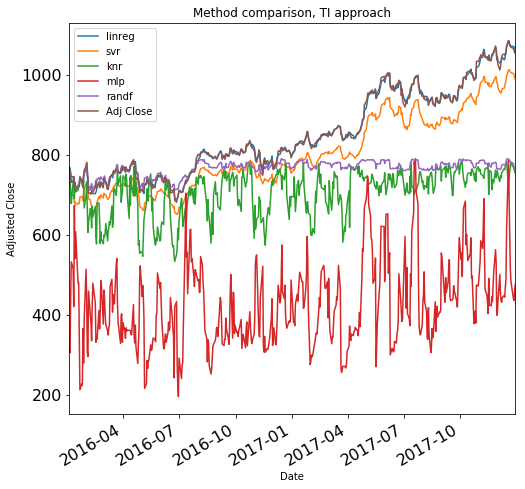

In [84]:
display(df_test.head())
ax = df_test.plot(title='Method comparison, TI approach', fontsize=16, figsize=(8, 8))
ax.set_xlabel('Date')
ax.set_ylabel('Adjusted Close')

### Predict BIDU stock prices with the second approach

In [85]:
methods = ['linreg', 'svr', 'knr', 'mlp', 'randf']
symbol = 'BIDU'
plotflag = False
if plotflag:
    # stock_plot(tddates,[adj_close, open_price, close_price, high_price, low_price],symbol)
    # stock_plot(tddates,df['Open', 'High', 'Low', 'Close'],symbol)
    stock_plot(tddates,adj_close,symbol)
# Specify data for training
startdate = datetime(2006,2,22).date()
enddate =  datetime(2015,12,31).date()
# Specify data for testing
teststdate = datetime(2016,1,1).date()
testeddate = datetime(2017,12,31).date()
# Frequency for choosing the testing dates
freq = 1
weekend = set([5, 6])
# Delete testing dates that are weekends
testdates = [teststdate + timedelta(days=x) for x in range(0,(testeddate-teststdate).days + 1,freq) 
     if (teststdate + timedelta(days=x)).weekday() not in weekend]
# 
results_ti = {}
df_test = pd.DataFrame()
for method in methods:
    result_ti, pred_train_ti, pred_test_ti, y_train_ti, y_test_ti, testdates_new_ti = stock_predtime(symbol,method, startdate, enddate, testdates)
    results_ti[method] = result_ti
    pred_test_ti = pd.DataFrame(data = pred_test_ti, columns=[method])
    if method == 'linreg':
        df_test = df_test.append(pred_test_ti)
    else:
        df_test = pd.concat([df_test, pred_test_ti],axis=1)
    # print(result_ti)
y_test_ti.columns=['True price']
df_test.index = y_test_ti.index
df_test = pd.concat([df_test, y_test_ti],axis=1)

results_df = pd.DataFrame(results_ti)
display(results_df)


[9.78226599e-01 1.98325528e-02 6.38297796e-05 1.36036634e-04
 3.74884058e-04 1.52020970e-04 6.48831042e-05 5.14520994e-04
 2.19163481e-04 1.97046681e-05 3.30415019e-04 6.53894274e-05]


knr     linreg         mlp      randf       svr
meanabsperc_test     7.095983   0.733374    9.958636   2.218977  0.980615
meanabsperc_train   28.017702  13.433934   69.787420   0.635851  8.058015
meansquare_test    303.832985   3.445250  566.710624  54.734514  6.356745
meansquare_train    10.018996   1.058686   25.010708   0.003799  0.599968
pred_time            0.047897   0.000758    0.001056   0.004000  0.039293
train_time           0.003325   0.003447    1.846394   0.318525  0.569456

linreg         svr         knr         mlp       randf  \
Date                                                                     
2016-01-04  185.501887  186.035002  188.205715  167.835081  183.498999   
2016-01-05  189.110298  187.681396  190.554286  149.393137  186.844998   
2016-01-06  185.705525  184.603645  189.500002  151.055463  185.821001   
2016-01-07  178.384091  178.684535  174.071429  189.516924  178.860997   
2016-01-08  174.790479  174.841738  173.089998  204.810668  171.415995   

             Adj Close  
Date                    
2016-01-04  184.029999  
2016-01-05  187.369995  
2016-01-06  185.610001  
2016-01-07  174.369995  
2016-01-08  171.339996

Text(0,0.5,u'Adjusted Close')

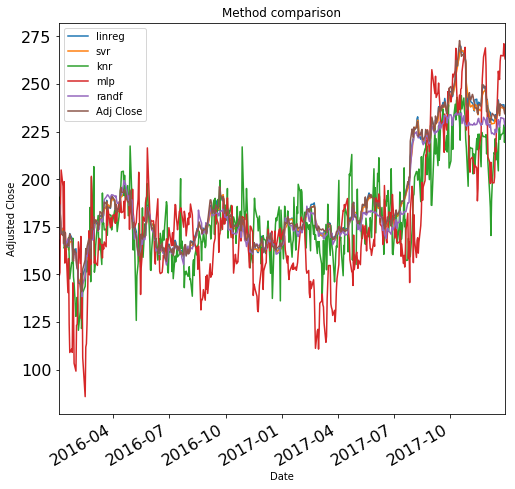

In [86]:
display(df_test.head())
ax = df_test.plot(title='Method comparison', fontsize=16, figsize=(8, 8))
ax.set_xlabel('Date')
ax.set_ylabel('Adjusted Close')

### Predict GOOGL stock prices with the LSTM networks

In [87]:
from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM

# def stock_lstm(symbol,method, startdate, enddate, testdates, lag, n_in):
symbol = 'BIDU'
""" Use LSTM network to predict stock prices """
# Obtain all data of given ticker symbol from 2006-02-22 to 2017-12-31
df = retrieve_data(symbol)
# Get dates from index
tddates = df.index.date
# Take the adjusted close prices only.
df_adj = df.drop(['Close', 'Volume', 'Open', 'High', 'Low'], axis=1)
# Convert the time series of price data to a supervised learning problem
# if lag=1, predit 1 day later. For example, use 2017.10.01 data to predict 2017.10.03 price
df_new = series_to_supervised(df_adj, n_in=1, lag=0, dropnan=False)
df_new = pd.concat([df.shift(1).drop('Adj Close',axis=1), df_new], axis=1)
df_new.dropna(inplace=True)
# Obtain traning data
X_train, y_train, testdates_new = get_data(df_new, tddates, startdate, enddate, testdates, trainflag=True, fcnflag=1)
# Obtain testing data
X_test, y_test, testdates_new = get_data(df_new, tddates, startdate, enddate, testdates, trainflag=False, fcnflag=1)
# display(X_train.head(), y_train.head(), X_test.head(), y_test.head())

# display(X_train.shape[0])
X_train = normal_data(X_train, 'minmax')
X_test = normal_data(X_test, 'minmax')
X_train = np.reshape(X_train.values, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test.values, (X_test.shape[0], 1, X_test.shape[1]))

# create a empty dictionary to record the results
results_LSTMs = {}

# design network
model = Sequential()
model.add(LSTM(units=128,return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.1))
model.add(LSTM(64,return_sequences=False))
model.add(Dense(1, activation="relu", kernel_initializer="uniform"))
model.compile(loss='mse', optimizer='rmsprop')

# fit network
start = time()
model.fit(X_train, y_train, epochs=300, batch_size=128, verbose=0, shuffle=False)
end = time()
results_LSTMs['train_time'] = end - start

# make a prediction
start = time()
y_test_pred = model.predict(X_test)
end = time()
results_LSTMs['pred_time'] = end - start

# evaluate model performance
# calculate errors, mean square and mean absolute percentage for the training set
sampletrain = 50
y_train_pred = model.predict(X_train[:sampletrain])
results_LSTMs['meansquare_train'] = mean_squared_error(y_train[:sampletrain], y_train_pred)
results_LSTMs['meanabsperc_train'] = mean_abs_percentage_error(y_train[:sampletrain], y_train_pred)
# calculate errors, mean square and mean absolute percentage for the test set
results_LSTMs['meansquare_test'] = mean_squared_error(y_test, y_test_pred)
results_LSTMs['meanabsperc_test'] = mean_abs_percentage_error(y_test, y_test_pred)

results_lstm = pd.DataFrame(results_LSTMs,index = [symbol+' LSTM model'])
display(results_lstm)

Using TensorFlow backend.


meanabsperc_test  meanabsperc_train  meansquare_test  \
BIDU LSTM model         54.447459          16.803668     10062.759244   

                 meansquare_train  pred_time  train_time  
BIDU LSTM model          0.892985   0.200466  128.461202